***RANDOM FOREST***


Addestramento del modello con Random Forest utilizzando i dati ripuliti in 'training_c.csv'

Importazione delle librerie necessarie e del dataset

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,confusion_matrix)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# Leggi il dataset
data = pd.read_csv('training_c.csv')

# Separa le feature (X) e la variabile target (y)
X = data.drop('RiskLevel', axis=1) 
y = data['RiskLevel']
data


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25.0,130,80.0,72.0,98,86.0,high risk
1,35.0,140,90.0,72.0,98,70.0,high risk
2,29.0,90,70.0,72.0,100,80.0,high risk
3,30.0,140,85.0,72.0,98,70.0,high risk
4,35.0,120,60.0,61.0,98,76.0,low risk
...,...,...,...,...,...,...,...
1004,48.0,120,80.0,72.0,98,88.0,high risk
1005,22.0,120,60.0,72.0,98,80.0,high risk
1006,55.0,120,90.0,72.0,98,60.0,high risk
1007,35.0,85,60.0,72.0,98,86.0,high risk


Divisione del dataset in training test e test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Creazione e addestramento del modello Random Forest

In [6]:
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuratezza iniziale: {accuracy:.4f}")


Accuratezza iniziale: 0.8861


Ottimizzazione con GridSearch degli iperparametri: numero di alberi (n_estimators) e profondità massima degli alberi (max_dept)

In [7]:
# Definisci il range di parametri da testare
param_grid = {
    'n_estimators': [50, 100, 200],  # Numero di alberi
    'max_depth': [None, 10, 20, 30],  # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],  # Numero minimo di campioni per dividere un nodo
    'min_samples_leaf': [1, 2, 4]  # Numero minimo di campioni in una foglia
}

# Inizializza GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # Numero di fold per la validazione incrociata
                           scoring='accuracy',
                           n_jobs=-1)

# Addestra con la ricerca dei parametri ottimali
grid_search.fit(X_train, y_train)

# Miglior modello trovato
best_model = grid_search.best_estimator_
print(f"Migliori parametri trovati: {grid_search.best_params_}")


Migliori parametri trovati: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Valutazione del modello ottimizzato sul test set

In [8]:
# Previsioni con il modello ottimizzato
y_pred_optimized = best_model.predict(X_test)

# Accuratezza
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Accuratezza con modello ottimizzato: {accuracy_optimized:.4f}")


Accuratezza con modello ottimizzato: 0.8713


Matrice di Confusione

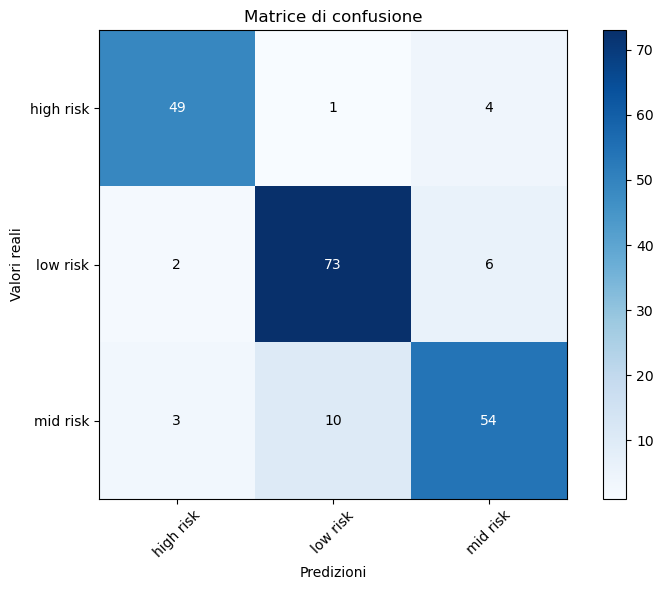

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

# Nome delle classi (sostituisci con i tuoi nomi reali, se presenti)
class_names = np.unique(y)  # Usa i nomi delle classi se sono disponibili

# Visualizza la matrice di confusione migliorata
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Matrice di confusione')
plt.colorbar()

# Aggiungi etichette agli assi
plt.xlabel('Predizioni')
plt.ylabel('Valori reali')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.yticks(np.arange(len(class_names)), class_names)

# Aggiungi i valori al centro di ogni quadrato
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j], 
                 ha='center', va='center', color='black' if conf_matrix[i, j] < conf_matrix.max() / 2 else 'white')

plt.tight_layout()
plt.show()


Realizzazione della **Curva di Apprendimento** 

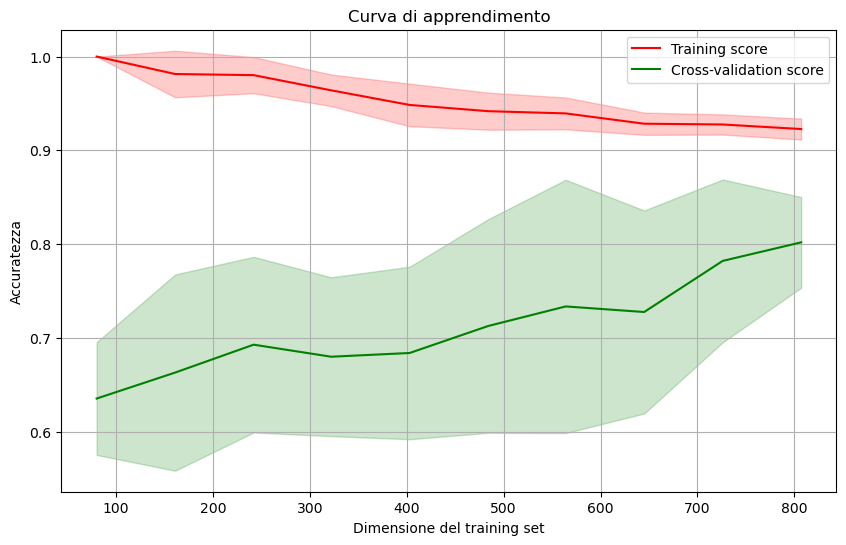

In [21]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy"
)
# Calcola medie e deviazioni standard
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Traccia la curva di apprendimento
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training score", color="r")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.title("Curva di apprendimento")
plt.xlabel("Dimensione del training set")
plt.ylabel("Accuratezza")
plt.legend(loc="best")
plt.grid()
plt.show()





Realizzazione della **Curva di Validazione**

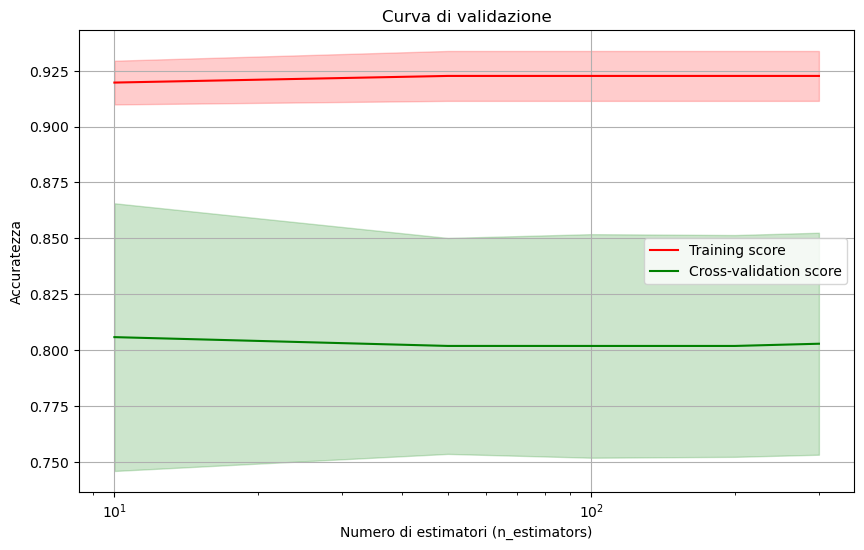

In [23]:
from sklearn.model_selection import validation_curve
param_range = [10, 50, 100, 200, 300]  # Esempio per il parametro 'n_estimators'
train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42), X, y, param_name="n_estimators", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)

# Calcola medie e deviazioni standard
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Traccia la curva di validazione
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.title("Curva di validazione")
plt.xlabel("Numero di estimatori (n_estimators)")
plt.ylabel("Accuratezza")
plt.xscale("log")
plt.legend(loc="best")
plt.grid()
plt.show()